In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/Users/andrewvolkov/Documents/Study/RecSys/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

# Оценивание
За выполнени каждого задания 1 балл

4 балла -> отл

3 балла -> хор

И тд

In [5]:
data['item_id'].nunique()

89051

### Задание 0. Товар 999999
На вебинаре мы использовали товар 999999 - что это за товар? 
##### Товар, которого нет в 5000 отобранных товаров.

Зачем он нужен?  
##### Что бы не потерять пользователей, если в списке их покупок есть товары, которых нет в наших 5000

##### Продолжение задания 0 - после задания 3

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. вес = log(sales_sum товара)
- Придумайте пример 3 весов, посчитайте weighted_random_recommendation для разных весов

In [6]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [7]:
w1 = data.set_index('item_id')

In [8]:
# веса - количество покупок данного товара
w1 = data.groupby('item_id').agg(sum)

In [9]:
w2 = w1.copy()

In [10]:
w3 = w1.copy()

In [11]:
w1['quantity'] = w1['quantity']/w1['quantity'].sum()

In [12]:
w1 = w1['quantity']

In [13]:
items = data.item_id.unique()

In [14]:
# проверка длины списков
len(items) == len(w1)

True

In [15]:
w1.sum()

1.0

In [16]:
w2['quantity'] = w2['quantity'] * np.log(w2['quantity'])

In [17]:
w2['quantity'] = w2['quantity']/w2['quantity'].sum()

In [18]:
w2 = w2['quantity']

In [19]:
len(items) == len(w2)

True

In [20]:
w2 = np.array(w2)

In [21]:
nans = np.argwhere(np.isnan(w2))

In [22]:
for nan in nans:
    w2[nan] = 0

In [23]:
w2.sum()

0.9999999999999993

In [24]:
w3['sales_value'] = w3['sales_value'] * (w3['coupon_disc']**2)

In [25]:
w3['sales_value'] = w3['sales_value']/w3['sales_value'].sum()

In [26]:
w3 = w3['sales_value']

In [27]:
w3.sum()

0.9999999999999998

In [28]:
def weighted_random_recommendation(items, weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    items = np.array(items)
    recs = np.random.choice(items, size=n, p=weights, replace=False)
    
    
    return recs.tolist()

In [29]:
weighted_random_recommendation(items, w1)

[1105730, 917347, 5802389, 899539, 2531432]

In [30]:
weighted_random_recommendation(items, w2)

[917347, 1105730, 1063199, 899539, 5802389]

In [31]:
weighted_random_recommendation(items, w3)

[9487963, 1439608, 9518040, 13007354, 1041278]

Сделайте предсказания

In [94]:
result = pd.read_csv('/Users/andrewvolkov/Documents/Study/RecSys/preds/preds_basic.csv')# закгрузка predict с семианара
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13776009, 1027721, 913414, 14024820, 1132246]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[981408, 875076, 13039824, 1035263, 13382158]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [95]:
%%time

# your_code

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items, w2, n=5))
result.head(2)

CPU times: user 5.76 s, sys: 545 ms, total: 6.3 s
Wall time: 6.52 s


,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13776009, 1027721, 913414, 14024820, 1132246]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]","[1105730, 917347, 2531432, 5802389, 844876]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[981408, 875076, 13039824, 1035263, 13382158]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]","[1105730, 5802389, 1033644, 899539, 825935]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма (с вебинара и weighted_random_recommendation) с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество? Почему?

In [33]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
#     print(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [34]:
result = pd.read_csv('/Users/andrewvolkov/Documents/Study/RecSys/preds/preds_basic.csv')# закгрузка predict с семианара
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13776009, 1027721, 913414, 14024820, 1132246]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[981408, 875076, 13039824, 1035263, 13382158]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [35]:
# ?map

In [36]:
cols = result.columns.drop(['user_id', 'actual'])

In [37]:
actual = result['actual'].map(lambda x: x[1:-1].split(', ')).apply(lambda x: list(map(int, x)))[0]

In [38]:
cols

Index(['random_recommendation', 'popular_recommendation', 'itemitem', 'cosine',
       'tfidf', 'own_purchases'],
      dtype='object')

In [39]:
metrics = {}

for method in cols:
    method_result = result[method].map(lambda x: x[1:-1].split(', ')).apply(lambda x: list(map(int, x)))[0]
    res = precision_at_k(method_result, actual)
    metrics[method] = res
    
metrics = pd.DataFrame(metrics.items(), columns=['method', 'precision@5'])
metrics

,method,precision@5
0,random_recommendation,0.0
1,popular_recommendation,0.2
2,itemitem,0.4
3,cosine,0.2
4,tfidf,0.2
5,own_purchases,0.4


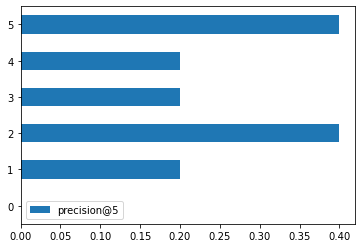

In [120]:
metrics.plot(kind='barh')

##### Если подгружаю result раньше, и добавляю weighted_recs, то все ломается с ошибкой list object has no atribute split. поэтому оставил тот вариант, что был на вебинаре.

##### Лучше всего показывает себя itemitem рекомендер.

In [40]:
# result.apply(lambda x: precision_at_k(x['popular_recommendation'], x['actual'],  5), axis=1)

### Задание 3. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.
- Попробуйте стратегии ансамблирования изученных алгоритмов


In [41]:
# your_code
popularity = data.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [42]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [134]:
# top_5000

In [129]:
# Заведем фиктивный item_id (если юзер НЕ покупал товары из топ-5000, то он "купил" такой товар)
data.loc[~data['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15926775,15926844,15926885,15926886,15926927,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [131]:
%%time

model = ItemItemRecommender(K=10, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 2.65 s, sys: 60.4 ms, total: 2.71 s
Wall time: 2.87 s


In [132]:
%%time

result['itemitem_k10'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 225 ms, sys: 130 ms, total: 355 ms
Wall time: 387 ms


In [48]:
%%time

model = ItemItemRecommender(K=20, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 2.67 s, sys: 56.7 ms, total: 2.73 s
Wall time: 2.98 s


In [49]:
%%time

result['itemitem_k20'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 153 ms, sys: 5.17 ms, total: 158 ms
Wall time: 167 ms


In [50]:
%%time

model = ItemItemRecommender(K=50, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 2.95 s, sys: 74.8 ms, total: 3.02 s
Wall time: 3.25 s


In [51]:
%%time

result['itemitem_k50'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 212 ms, sys: 4.69 ms, total: 217 ms
Wall time: 228 ms


In [52]:
%%time

model = ItemItemRecommender(K=3, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 2.6 s, sys: 52.6 ms, total: 2.66 s
Wall time: 2.82 s


In [53]:
%%time

result['itemitem_k3'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 86.6 ms, sys: 3.95 ms, total: 90.6 ms
Wall time: 102 ms


In [54]:
result.head(1)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,itemitem_k10,itemitem_k20,itemitem_k50,itemitem_k3
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13776009, 1027721, 913414, 14024820, 1132246]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 1029743]"


In [55]:
cols = result.columns.drop(['user_id', 'actual'])

In [56]:
cols

Index(['random_recommendation', 'popular_recommendation', 'itemitem', 'cosine',
       'tfidf', 'own_purchases', 'itemitem_k10', 'itemitem_k20',
       'itemitem_k50', 'itemitem_k3'],
      dtype='object')

In [57]:
k10 = np.array(result['itemitem_k10'])
k20 = np.array(result['itemitem_k20'])
k50 = np.array(result['itemitem_k50'])
k3 = np.array(result['itemitem_k3'])

In [58]:
precision_at_k(k10[0], actual)

0.4

In [59]:
precision_at_k(k20[0], actual)

0.4

In [60]:
precision_at_k(k50[0], actual)

0.4

In [61]:
precision_at_k(k3[0], actual)

0.4

##### При изменении количества "соседей", качество не изменяется. Про ансамблирование - не понял что с ними делать. 

##### Посчитал только так, потому что даже при вставке в ноутбук с вебинара получаю ошибку "'list' object has no attribute 'split'" при использовании "result[ANY_COLUMN].map(lambda x: x[1:-1].split(', ')).apply(lambda x: list(map(int, x)))[0]"

### Продолжение задания 0

In [82]:
data_test = data[data['item_id'] != 999999]

In [83]:
data_test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [122]:
# теряем 875 тысяч транзакций
data_test.shape[0] - data.shape[0]

-875675

In [85]:
user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 
user_item_matrix = user_item_matrix.astype(float) 

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15926775,15926844,15926885,15926886,15926927,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [88]:
# Для сравнения используем ItemItemRecommender с параметрами как на уроке
# %%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [90]:
recs

[(3407, 72598.0),
 (2143, 59891.0),
 (3585, 20387.0),
 (3947, 20303.0),
 (2304, 19347.0)]

In [92]:
test_recs = [id_to_itemid[rec[0]] for rec in recs]

In [93]:
precision_at_k(test_recs, actual)

0.2

Используя этот товар мы смещаем качество рекомендаций.
В какую сторону? 

Можно ли удалить этот товар?   
Уберите этот товар и сравните с качеством на семинаре.

##### Используя товар 999999 - мы увеличиваем качество прогноза, т.к. не теряем операции пользователей, которые покупали не популярные товары. Качество уменьшилось после удаления item_id = 999999

##### С заданием 4 не знаю как подступиться. Посмотрел бы на разборе, как делать и с чего вообще начать применение этих формул.

### Задание 4. Улучшение детерминированных алгоритмов
На семинаре мы рассматривали 



Далее $U \equiv N_i(u) $

$$r_{u,i} =  \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)r_{v, i}$$
$$ S = \sum\limits_{v \in U} \operatorname{sim}(u,v)$$

Предлагается улучшить эту формулу и учесть средние предпочтения всех пользователей

$$r_{u,i} = \mu + \bar{r_u} + \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)(r_{v, i}-\bar{r_{v}} - \mu)$$

Какие смысл имееют $ \mu $ и $ \bar{r_u}$ ?

Реализуйте алгоритм, прогнозирующий рейтинги на основе данной формулы, на numpy (векторизованно!)

В качестве схожести возьмите CosineSimilarity.

Примените к user_item_matrix. В качестве рейтингов возьмите количество или стоимость купленного товара. 
Данный алгоритм предсказывает рейтинги. Как на основании предсказанных рейтингов предсказать факт покупки?

Предложите вариант.
Посчитайте accuracy@5 и сравните с алгоритмами, разобранными на вебинаре.